In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


## Загрузка данных

In [12]:
path_to_data = r'movie_reviews'
data = pd.DataFrame()

for document in range(12500):
    with open(path_to_data + r'/train/neg/{}.txt'.format(document), 'r', encoding='utf-8') as f:
        data = data.append(pd.DataFrame({'label': 0, 'txt': [f.read()]}), ignore_index=True)
        
for document in range(12500):
    with open(path_to_data + r'/train/pos/{}.txt'.format(document), 'r', encoding='utf-8') as f:
        data = data.append(pd.DataFrame({'label': 1, 'txt': [f.read()]}), ignore_index=True)

In [14]:
test = pd.DataFrame()

for document in range(25000):
    with open(path_to_data + r'/test/{}.txt'.format(document), 'r', encoding='utf-8') as f:
        test = test.append(pd.DataFrame({'label': [-1], 'txt': [f.read()]}), ignore_index=True)

In [15]:
unsup = pd.DataFrame()

for document in range(50000):
    with open(path_to_data + r'/unsup/{}_0.txt'.format(document), 'r', encoding='utf-8') as f:
        unsup = unsup.append(pd.DataFrame({'label': [-1], 'txt': [f.read()]}), ignore_index=True)

In [16]:
data.to_csv(r'train.csv', index=False)
test.to_csv(r'test.csv', index=False)
unsup.to_csv(r'unsup.csv', index=False)

## Загрузка размеченых данных

In [18]:
data = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')
unsup = pd.read_csv(r'unsup.csv')

data_rating_pos = pd.read_csv(r'neg_rating.csv')
data_rating_neg = pd.read_csv(r'pos_rating.csv')

In [19]:
data_rating = pd.concat([data_rating_pos,data_rating_neg], axis=0)

In [21]:
data_for_ratings = data.txt

In [23]:
only_rating = data_rating.rating

In [24]:
only_rating.value_counts()

1     4994
10    4858
8     2931
4     2605
3     2586
7     2466
2     2315
9     2245
Name: rating, dtype: int64

In [25]:
X = data['txt']
y = data['label']

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.23, stratify=y)

X_train_raiting, X_val_raiting, y_train_raiting, y_val_raiting = train_test_split(data_for_ratings, only_rating, test_size=0.23, stratify=only_rating)

In [38]:
tokenizer = Tokenizer(num_words=14000)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [ ]:
X_train

In [29]:
tokenizer2 = Tokenizer(num_words=14000)

tokenizer2.fit_on_texts(list(X_train_raiting))
X_train_raiting = tokenizer2.texts_to_sequences(X_train_raiting)
X_val_raiting = tokenizer2.texts_to_sequences(X_val_raiting)

In [30]:
max_words = 1000
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)

In [31]:
max_words = 1000
X_train_raiting = sequence.pad_sequences(X_train_raiting, maxlen=max_words)
X_val_raiting = sequence.pad_sequences(X_val_raiting, maxlen=max_words)

In [32]:
y_train_raiting_dummy = to_categorical(y_train_raiting, 11)
y_val_raiting_dummy = to_categorical(y_val_raiting, 11)

In [202]:
y_train_raiting.head()

3183     10
11253     2
6118      1
11515     9
2474      3
Name: rating, dtype: int64

In [203]:
print(y_train_raiting_dummy[0])
print(y_train_raiting_dummy[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


я не удалял стоп слова, потому что они иногда хорошо влияют на контекст

### LSTM with Glove Embedding (одна модель предиктит метки класа, вторая рейтинг)

In [0]:
def model_train(model):
    model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                          epochs=epochs, batch_size=batch_size, verbose=1)
    plot_model_history(model_history)

In [0]:
def model_ratings_train(model):
    model_history = model.fit(X_train_raiting, y_train_raiting_dummy, validation_data=(X_val_raiting, y_val_raiting_dummy), 
                          epochs=epochs, batch_size=batch_size, verbose=1)
    plot_model_history(model_history)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def model_evaluate(): 

    y_pred_val =  model.predict_classes(X_val, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(y_val, y_pred_val)*100))
    

    print('\n')
    print(classification_report(y_val, y_pred_val))


    confmat = confusion_matrix(y_val, y_pred_val)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

In [0]:
def model_raitings_evaluate(): 

    y_pred_val =  model.predict_classes(X_val_raiting, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(y_val_raiting, y_pred_val)*100))

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=20000):
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

In [0]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(42)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix]))#,trainable=False
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [0]:
def get_model_raitings(max_features, embed_dim, embedding_matrix):
    np.random.seed(42)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train_raiting.shape[1],
                       weights=[embedding_matrix]))#,trainable=False
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

## Модель для меток на 5 епох

Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 19250 samples, validate on 5750 samples
Epoch 1/5
19250/19250 [==============================] - 238s 12ms/step - loss: 0.6265 - acc: 0.6434 - val_loss: 0.5321 - val_acc: 0.7332
Epoch 2/5
19250/19250 [==============================] - 237s 12ms/step - loss: 0.5225 - acc: 0.7460 - val_loss: 0.5686 - val_acc: 0.6943
Epoch 3/5
19250/19250 [================

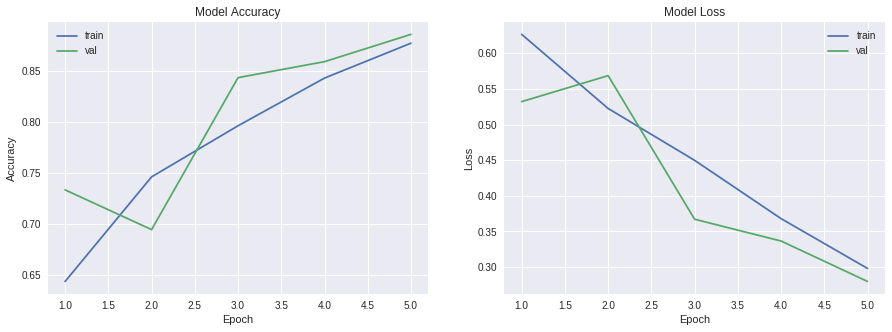

In [0]:
batch_size = 256
epochs = 5
embed_dim = 100
EMBEDDING_FILE = r'your_path/glove.6B.100d.txt'

max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

## Модель для рейтинга на 5 епох

Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 2,081,511
Trainable params: 2,081,511
Non-trainable params: 0
_________________________________________________________________
None
Train on 19250 samples, validate on 5750 samples
Epoch 1/5
19250/19250 [==============================] - 253s 13ms/step - loss: 2.0651 - acc: 0.2025 - val_loss: 2.0256 - val_acc: 0.2113
Epoch 2/5
19250/19250 [==============================] - 252s 13ms/step - loss: 2.0011 - acc: 0.2374 - val_loss: 1.9889 - val_acc: 0.2532
Epoch 3/5
19250/19250 [================

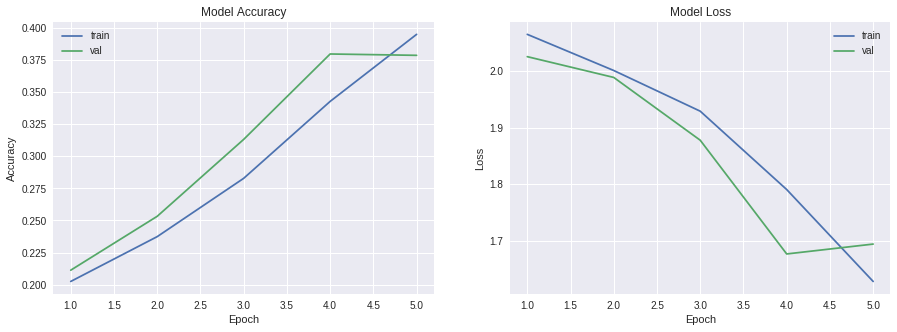

In [212]:
batch_size = 256
epochs = 5
embed_dim = 100
EMBEDDING_FILE = r'your_path\glove.6B.100d.txt'

max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

model_rating = get_model_raitings(max_features, embed_dim, embedding_matrix)
model_ratings_train(model_rating)

## Модель для меток на 6 епох

Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 19250 samples, validate on 5750 samples
Epoch 1/6
19250/19250 [==============================] - 238s 12ms/step - loss: 0.6279 - acc: 0.6415 - val_loss: 0.4986 - val_acc: 0.7680
Epoch 2/6
19250/19250 [==============================] - 236s 12ms/step - loss: 0.5057 - acc: 0.7578 - val_loss: 0.4142 - val_acc: 0.8177
Epoch 3/6
19250/19250 [================

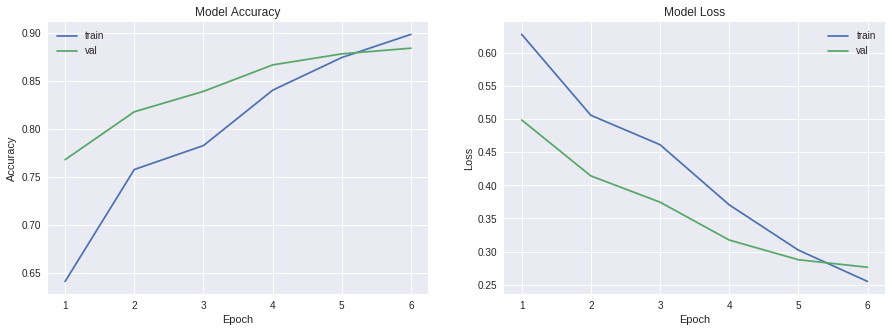

In [0]:
batch_size = 256
epochs = 6

max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

In [0]:
X_test = tokenizer.texts_to_sequences(test['txt'])
X_unsup = tokenizer.texts_to_sequences(unsup['txt'])

In [0]:
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
X_unsup = sequence.pad_sequences(X_unsup, maxlen=max_words)

In [0]:
X_test.shape, X_unsup.shape

((25000, 1000), (50000, 1000))

In [0]:
test.head()

,label,txt
0,-1,Drug runner Archie Moses introduces his friend...
1,-1,Before Sunrise is romance for the slacker gene...
2,-1,"A Three Stooges short, this one featuring Shem..."
3,-1,I saw this film for one reason: the tagline is...
4,-1,A woman (Sylvia Kristel) seduces a 15 year old...


## Предикшн на unsup и test Используем модели на 5 епох

In [0]:
test['id'] = test.index.values

test['label'] = model.predict_classes(X_test, batch_size=batch_size)


In [0]:
test.sample(15)

,label,txt,id
1430,1,"When I first saw this movie,I also expected ""o...",1430
5129,0,"This movie is written by Charlie Higson, who h...",5129
10324,1,This movie is really funny!! The General is Ke...,10324
14925,1,Personal taste rules when it comes to talking ...,14925
17698,1,I watched this movie as a child and still enjo...,17698
22937,1,Truly I Love Lucy as well...comedic genius yes...,22937
13442,1,"Hey guys, <br /><br />i have been looking ever...",13442
5260,0,hey ....i really do not know why this film has...,5260
10539,1,Out of the first five episodes of Hammer's sho...,10539
13652,1,This was my first Gaspar Noe movie I've watche...,13652


In [0]:
X_test_raiting = tokenizer2.texts_to_sequences(test['txt'])
X_unsup_raiting = tokenizer2.texts_to_sequences(unsup['txt'])

X_test_raiting = sequence.pad_sequences(X_test_raiting, maxlen=max_words)
X_unsup_raiting = sequence.pad_sequences(X_unsup_raiting, maxlen=max_words)

In [0]:
test['rating'] = model_rating.predict_classes(X_test_raiting, batch_size=batch_size)

In [0]:
unsup['id'] = unsup.index.values

unsup['label'] = model.predict_classes(X_unsup, batch_size=batch_size)

unsup.sample(15)

,label,txt,id
33220,1,Im in one in two minds- so Ill do two reviews!...,33220
2219,1,"In the city of Suddenly, three gangsters trap ...",2219
47116,0,"Oh dear, what a let-down. This movie left me w...",47116
45385,0,"Like another reviewer of this movie, I found m...",45385
6024,1,Vicky Lowndes (Jean Arthur) leads a normal lif...,6024
26181,1,Really just another attempt to squeeze some ju...,26181
11848,1,From the writer of Im ai ni yukimasu ( that ha...,11848
3710,1,"This, despite its weaknesses, is quite a good ...",3710
4947,1,A fantasy film like 'Field of Dreams' with exc...,4947
44235,0,This is just another mediocre action flick wit...,44235


In [0]:
unsup['rating'] = model_rating.predict_classes(X_unsup_raiting, batch_size=batch_size)

## Выгрузка ответов

In [0]:
test.to_csv('test_predictions.csv', index=False)
unsup.to_csv('unsup_predictions.csv', index=False)